# Refinery Margins - Dual Display Demo

This notebook demonstrates **both visualization approaches** side-by-side:
- 📊 **Static PNG panels** (matplotlib)
- 🎨 **Interactive HTML panels** (Plotly)

**Same data, two different experiences!**

## What This Demo Shows

1. ✅ How to create displays with both matplotlib and Plotly
2. ✅ Automatic panel type detection
3. ✅ Launch both displays for side-by-side comparison
4. ✅ Performance and file size differences
5. ✅ When to use each approach

## Display Comparison

| Feature | Matplotlib (PNG) | Plotly (HTML) |
|---------|------------------|---------------|
| Port | 8763 | 8764 |
| Panel Size | ~64KB | ~16KB |
| Loading | <1 second | 1-2 seconds |
| Interactivity | None | Full (hover, zoom, pan) |
| Use Case | Reports, exports | Data exploration |

In [1]:
import sys
from pathlib import Path

# Add parent directory to path
sys.path.insert(0, str(Path.cwd().parent))

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly
import plotly.graph_objects as go
import subprocess
import time
import webbrowser
import os
import signal

from trelliscope import Display
from trelliscope.meta import FactorMeta, NumberMeta

print("✓ All imports successful")
print(f"  Matplotlib version: {plt.matplotlib.__version__}")
print(f"  Plotly version: {plotly.__version__}")

✓ All imports successful
  Matplotlib version: 3.10.0
  Plotly version: 6.0.1


In [2]:
# IMPORTANT: Clear cached trelliscope modules to ensure we use the latest code
# This cell should be run FIRST if you've made changes to the trelliscope package
import sys

# Remove any cached trelliscope modules
cached_modules = [key for key in sys.modules.keys() if key.startswith('trelliscope')]
for module in cached_modules:
    del sys.modules[module]

if cached_modules:
    print(f"✅ Cleared {len(cached_modules)} cached trelliscope modules")
    print("   Modules will be reloaded with latest code")
else:
    print("✅ No cached modules - fresh import")

print("\n💡 This ensures you get:")
print("   • Country metadata fix (1-based factor indexing)")
print("   • Responsive plot support (autosize=True)")
print("   • Latest serialization enhancements")

✅ Cleared 15 cached trelliscope modules
   Modules will be reloaded with latest code

💡 This ensures you get:
   • Country metadata fix (1-based factor indexing)
   • Responsive plot support (autosize=True)
   • Latest serialization enhancements


## 1. Load and Explore Data

We'll use the same refinery margins dataset for both displays.

In [3]:
# Load refinery margins data
data_path = Path("../_data/refinery_margins.csv")

print(f"Loading data from: {data_path.absolute()}")
df = pd.read_csv(data_path)
df['date'] = pd.to_datetime(df['date'])

print(f"\n✓ Loaded {len(df):,} rows")
print(f"\nData shape: {df.shape}")
print(f"Date range: {df['date'].min().date()} to {df['date'].max().date()}")

# Get countries
countries = sorted(df['country'].unique())
print(f"\nCountries ({len(countries)}):")
for i, country in enumerate(countries, 1):
    print(f"  {i}. {country}")

Loading data from: /Users/matthewdeane/Documents/Data Science/python/_projects/py-trelliscope2/examples/../_data/refinery_margins.csv

✓ Loaded 1,920 rows

Data shape: (1920, 20)
Date range: 2006-01-01 to 2021-12-01

Countries (10):
  1. Algeria
  2. Denmark
  3. Germany
  4. Italy
  5. Netherlands
  6. Norway
  7. Romania
  8. Russian Federation
  9. Turkey
  10. United Kingdom


## 2. Create Matplotlib Plot Function

First, we'll create a function for **static PNG** plots using matplotlib.

In [4]:
def create_matplotlib_plot(country_data, country_name):
    """
    Create static matplotlib plot.
    
    Features:
    - Line plot with points
    - Grid for readability
    - Professional styling
    
    Returns matplotlib Figure
    """
    fig, ax = plt.subplots(figsize=(8, 5))
    
    # Plot line and points
    ax.plot(country_data['date'], country_data['refinery_kbd'], 
            color='#2c7fb8', linewidth=2, marker='o', markersize=3, 
            markerfacecolor='#2c7fb8', markeredgewidth=0)
    
    # Format x-axis dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    
    # Labels and title
    ax.set_title(f"Refinery Capacity - {country_name}", fontsize=12, fontweight='bold')
    ax.set_xlabel("Date", fontsize=10)
    ax.set_ylabel("Refinery (kbd)", fontsize=10)
    
    # Grid
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    
    plt.tight_layout()
    
    return fig

# Test with one country
test_country = 'Germany'
test_data = df[df['country'] == test_country].copy()
test_fig = create_matplotlib_plot(test_data, test_country)

# Close the test figure to free memory
plt.close(test_fig)

print(f"✓ Matplotlib plot function works!")
print(f"✓ Created test figure for {test_country}")
print("✓ Test figure closed to free memory")

✓ Matplotlib plot function works!
✓ Created test figure for Germany
✓ Test figure closed to free memory


## 3. Create Plotly Plot Function

Now we'll create a function for **interactive HTML** plots using Plotly.

In [5]:
def create_plotly_plot(country_data, country_name):
    """
    Create interactive Plotly plot.
    
    Features:
    - Line plot with markers
    - Hover tooltips
    - Zoom and pan controls
    - Professional styling
    
    Returns plotly Figure
    """
    fig = go.Figure()
    
    # Add line trace with markers
    fig.add_trace(go.Scatter(
        x=country_data['date'],
        y=country_data['refinery_kbd'],
        mode='lines+markers',
        name='Refinery Capacity',
        line=dict(color='#2c7fb8', width=2),
        marker=dict(size=4, color='#2c7fb8'),
        hovertemplate='<b>Date:</b> %{x|%Y-%m-%d}<br>' +
                      '<b>Capacity:</b> %{y:.1f} kbd<br>' +
                      '<extra></extra>'
    ))
    
    # Update layout
    fig.update_layout(
        title=f"Refinery Capacity - {country_name}",
        xaxis_title='Date',
        yaxis_title='Refinery (kbd)',
        plot_bgcolor='white',
        paper_bgcolor='white',
        hovermode='closest',
        showlegend=False,
        width=500,
        height=400,
        margin=dict(l=60, r=20, t=40, b=60)
    )
    
    # Add grid styling
    fig.update_xaxes(showgrid=True, gridcolor='#e0e0e0', gridwidth=0.5)
    fig.update_yaxes(showgrid=True, gridcolor='#e0e0e0', gridwidth=0.5)
    
    return fig

def create_plotly_plot_responsive(country_data, country_name):
    """
    Create RESPONSIVE interactive Plotly plot.
    
    Key difference: Uses autosize=True instead of fixed width/height.
    This makes panels resize when you change viewer layout!
    
    Returns plotly Figure
    """
    fig = go.Figure()
    
    # Add line trace with markers
    fig.add_trace(go.Scatter(
        x=country_data['date'],
        y=country_data['refinery_kbd'],
        mode='lines+markers',
        name='Refinery Capacity',
        line=dict(color='#2c7fb8', width=2),
        marker=dict(size=4, color='#2c7fb8'),
        hovertemplate='<b>Date:</b> %{x|%Y-%m-%d}<br>' +
                      '<b>Capacity:</b> %{y:.1f} kbd<br>' +
                      '<extra></extra>'
    ))
    
    # Update layout - KEY CHANGES:
    # - autosize=True instead of fixed width/height
    # - Panels will now resize based on viewer layout
    fig.update_layout(
        title=f"Refinery Capacity - {country_name}",
        xaxis_title='Date',
        yaxis_title='Refinery (kbd)',
        plot_bgcolor='white',
        paper_bgcolor='white',
        hovermode='closest',
        showlegend=False,
        autosize=True,  # ← KEY: Makes plot responsive
        # NO fixed width or height!
        margin=dict(l=60, r=20, t=40, b=60)
    )
    
    # Add grid styling
    fig.update_xaxes(showgrid=True, gridcolor='#e0e0e0', gridwidth=0.5)
    fig.update_yaxes(showgrid=True, gridcolor='#e0e0e0', gridwidth=0.5)
    
    return fig

print("✓ Responsive Plotly plot function defined!")
print("\nTo use this version:")
print("1. In cell #9, replace 'create_plotly_plot' with 'create_plotly_plot_responsive'")
print("2. Re-run cells 9, 13 to regenerate the Plotly display")
print("3. Restart server (cell #17)")
print("4. Panels will now resize when you change layout columns!")
print("\n⚠️  Note: Only run this cell if you've already run cells 1-7 first!")

# Test with same country
test_fig_plotly = create_plotly_plot_responsive(test_data, test_country)

print(f"✓ Plotly plot function works!")
print(f"✓ Created test figure for {test_country}")
print("\nNote: Figure display removed to prevent kernel crashes.")
print("You'll see the interactive plots in the viewer after running all cells!")

✓ Responsive Plotly plot function defined!

To use this version:
1. In cell #9, replace 'create_plotly_plot' with 'create_plotly_plot_responsive'
2. Re-run cells 9, 13 to regenerate the Plotly display
3. Restart server (cell #17)
4. Panels will now resize when you change layout columns!

⚠️  Note: Only run this cell if you've already run cells 1-7 first!
✓ Plotly plot function works!
✓ Created test figure for Germany

Note: Figure display removed to prevent kernel crashes.
You'll see the interactive plots in the viewer after running all cells!


## 4. Create Both Displays

Now we'll create both displays with the same data but different visualization libraries.

Creating display data for all countries...
  ✓ Algeria: avg=497.7 kbd
  ✓ Denmark: avg=152.2 kbd
  ✓ Germany: avg=1947.0 kbd
  ✓ Italy: avg=1463.6 kbd
  ✓ Netherlands: avg=1029.4 kbd
  ✓ Norway: avg=290.8 kbd
  ✓ Romania: avg=226.1 kbd
  ✓ Russian Federation: avg=5367.6 kbd
  ✓ Turkey: avg=502.0 kbd
  ✓ United Kingdom: avg=1255.2 kbd

✓ Created 10 matplotlib panels
✓ Created 10 Plotly panels (responsive)


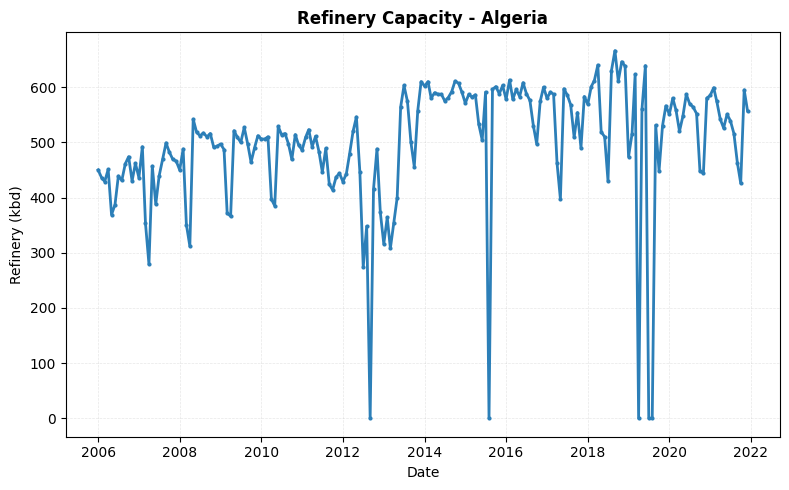

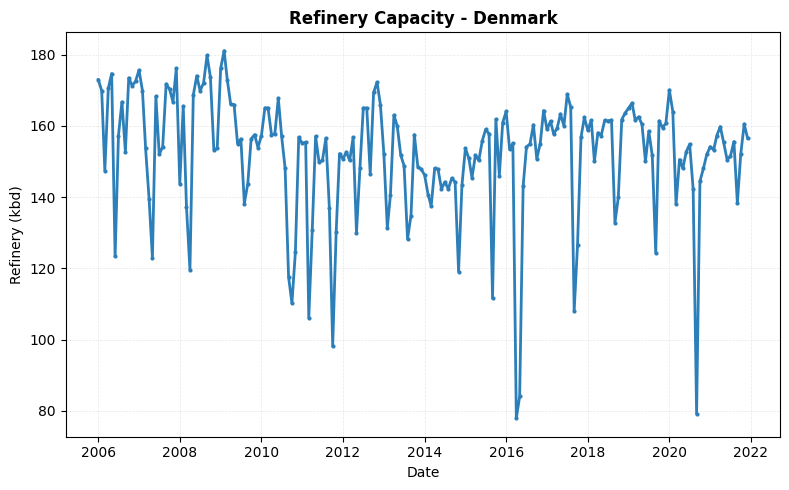

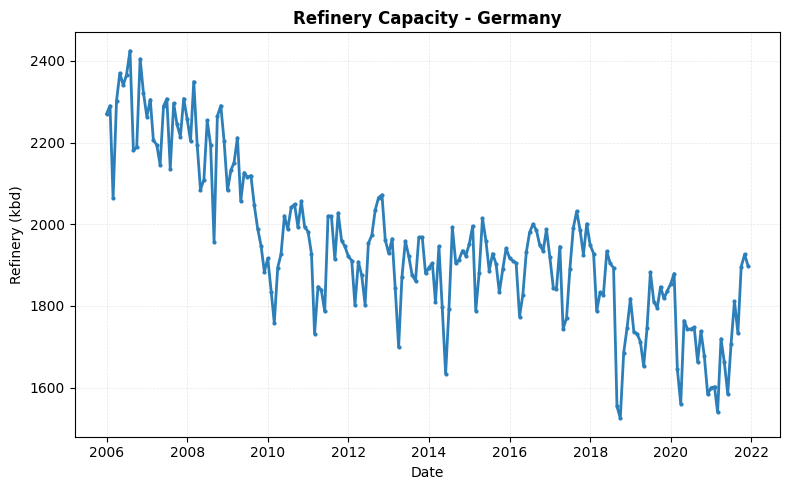

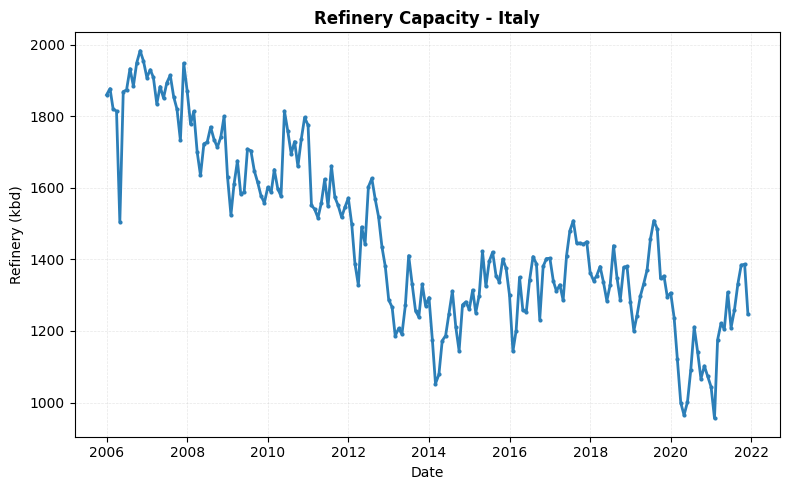

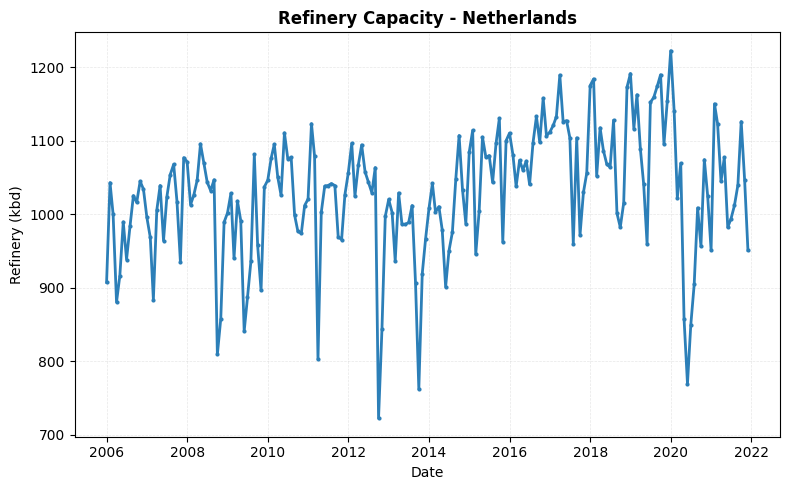

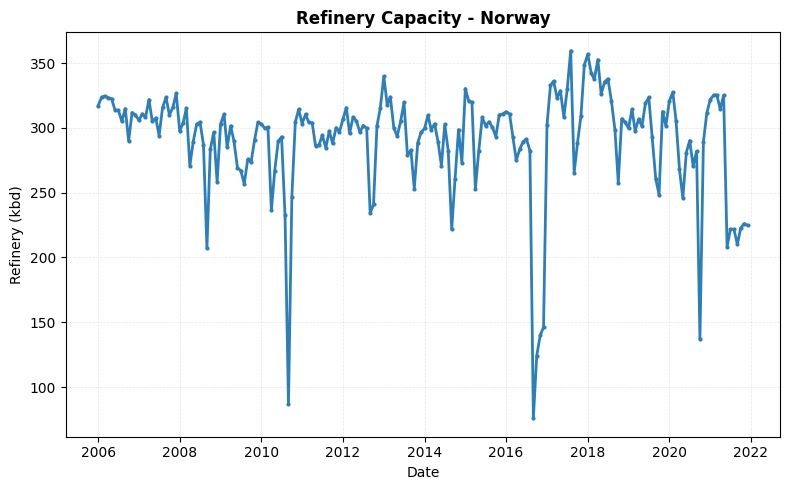

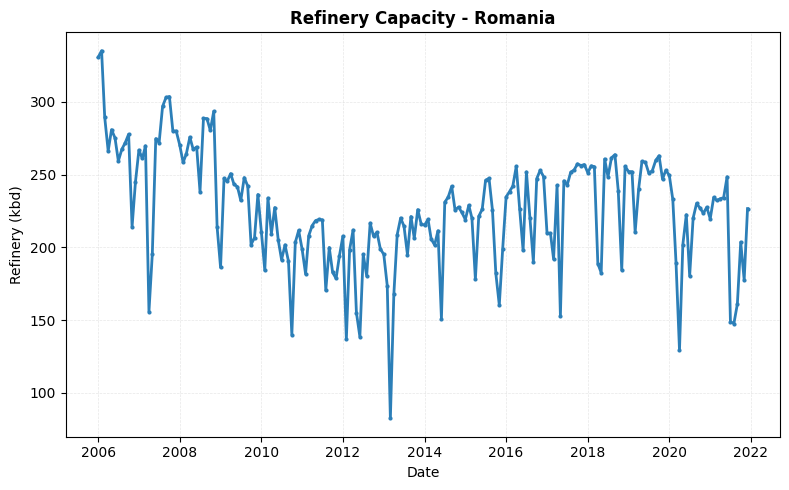

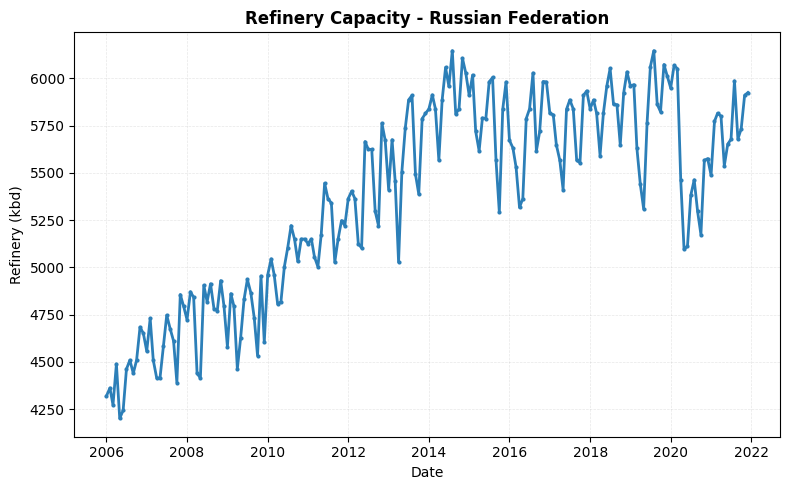

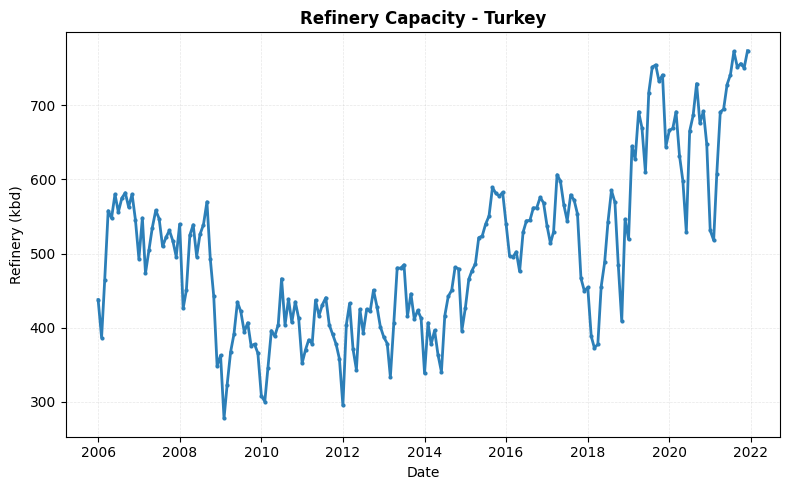

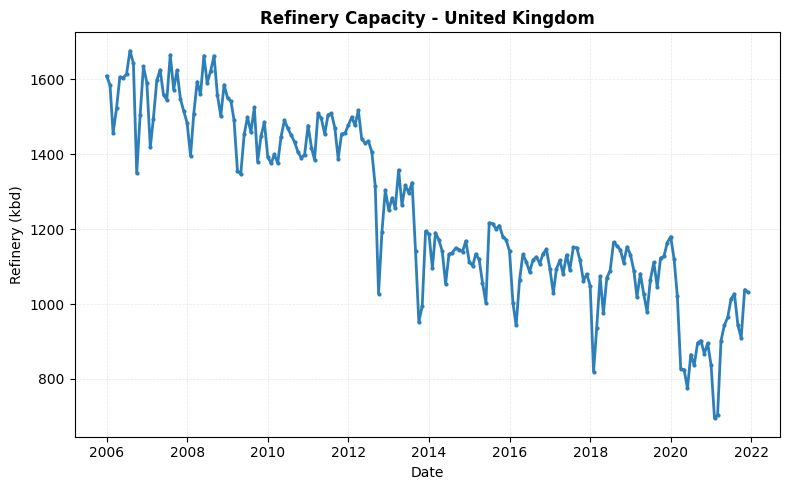

In [6]:
print("Creating display data for all countries...")
print("="*70)

# Prepare data for both displays (same structure)
matplotlib_data = []
plotly_data = []

for country in countries:
    country_df = df[df['country'] == country].copy()
    
    # Calculate summary statistics (same for both)
    stats = {
        'country': country,
        'avg_capacity': country_df['refinery_kbd'].mean(),
        'max_capacity': country_df['refinery_kbd'].max(),
        'min_capacity': country_df['refinery_kbd'].min(),
        'n_obs': len(country_df)
    }
    
    # Create matplotlib figure
    matplotlib_fig = create_matplotlib_plot(country_df, country)
    matplotlib_data.append({**stats, 'panel': matplotlib_fig})
    
    # Create Plotly figure (RESPONSIVE - resizes with layout!)
    plotly_fig = create_plotly_plot_responsive(country_df, country)
    plotly_data.append({**stats, 'panel': plotly_fig})
    
    print(f"  ✓ {country}: avg={stats['avg_capacity']:.1f} kbd")

# Convert to DataFrames
matplotlib_df = pd.DataFrame(matplotlib_data)
plotly_df = pd.DataFrame(plotly_data)

print(f"\n✓ Created {len(matplotlib_df)} matplotlib panels")
print(f"✓ Created {len(plotly_df)} Plotly panels (responsive)")

## 5. Create Matplotlib Display (Static PNG)

First display with static PNG panels.

In [7]:
print("Creating Matplotlib display...")
print("="*70)

# Create display
matplotlib_display = Display(
    matplotlib_df,
    name="refinery_by_country",
    description="Refinery Capacity by Country - Static PNG (Matplotlib)"
)

# Configure
matplotlib_display.set_panel_column("panel")
matplotlib_display.add_meta_variable(
    FactorMeta(varname="country", label="Country", levels=sorted(countries))
)
matplotlib_display.add_meta_variable(
    NumberMeta(varname="avg_capacity", label="Avg Capacity (kbd)", digits=1)
)
matplotlib_display.add_meta_variable(
    NumberMeta(varname="max_capacity", label="Max Capacity (kbd)", digits=1)
)
matplotlib_display.add_meta_variable(
    NumberMeta(varname="min_capacity", label="Min Capacity (kbd)", digits=1)
)
matplotlib_display.add_meta_variable(
    NumberMeta(varname="n_obs", label="# Observations", digits=0)
)
matplotlib_display.set_default_layout(ncol=3, nrow=2, arrangement="row")
matplotlib_display.set_default_labels(["country", "avg_capacity"])

# Write
matplotlib_output = Path("output/refinery_by_country")
matplotlib_display.write(output_path=matplotlib_output, force=True, viewer_debug=False)

# Close matplotlib figures
plt.close('all')

print(f"\n✅ Matplotlib display created at {matplotlib_output}")
print(f"   Panel type: PNG (static images)")

Creating Matplotlib display...
Rendering 10 panels...
  Rendered panel 0: 0.png
  Rendered panel 1: 1.png
  Rendered panel 2: 2.png
  Rendered panel 3: 3.png
  Rendered panel 4: 4.png
  Rendered panel 5: 5.png
  Rendered panel 6: 6.png
  Rendered panel 7: 7.png
  Rendered panel 8: 8.png
  Rendered panel 9: 9.png
  Generated index.html viewer at output/refinery_by_country

✅ Matplotlib display created at output/refinery_by_country
   Panel type: PNG (static images)


## 6. Create Plotly Display (Interactive HTML)

Second display with interactive HTML panels.

In [8]:
print("Creating Plotly display...")
print("="*70)

# Create display
plotly_display = Display(
    plotly_df,
    name="refinery_plotly",
    description="Refinery Capacity by Country - Interactive HTML (Plotly)"
)

# Configure (same as matplotlib)
plotly_display.set_panel_column("panel")
plotly_display.add_meta_variable(
    FactorMeta(varname="country", label="Country", levels=sorted(countries))
)
plotly_display.add_meta_variable(
    NumberMeta(varname="avg_capacity", label="Avg Capacity (kbd)", digits=1)
)
plotly_display.add_meta_variable(
    NumberMeta(varname="max_capacity", label="Max Capacity (kbd)", digits=1)
)
plotly_display.add_meta_variable(
    NumberMeta(varname="min_capacity", label="Min Capacity (kbd)", digits=1)
)
plotly_display.add_meta_variable(
    NumberMeta(varname="n_obs", label="# Observations", digits=0)
)
plotly_display.set_default_layout(ncol=3, nrow=2, arrangement="row")
plotly_display.set_default_labels(["country", "avg_capacity"])

# Write
plotly_output = Path("output/refinery_plotly")
plotly_display.write(output_path=plotly_output, force=True, viewer_debug=False)

print(f"\n✅ Plotly display created at {plotly_output}")
print(f"   Panel type: HTML (interactive iframes)")

Creating Plotly display...
Rendering 10 panels...
  Rendered panel 0: 0.html
  Rendered panel 1: 1.html
  Rendered panel 2: 2.html
  Rendered panel 3: 3.html
  Rendered panel 4: 4.html
  Rendered panel 5: 5.html
  Rendered panel 6: 6.html
  Rendered panel 7: 7.html
  Rendered panel 8: 8.html
  Rendered panel 9: 9.html
  Generated index.html viewer at output/refinery_plotly

✅ Plotly display created at output/refinery_plotly
   Panel type: HTML (interactive iframes)


## 7. Compare File Sizes

Let's see the actual file sizes for both panel types.

In [9]:
print("\nFile Size Comparison")
print("="*70)

# Get panel file sizes
matplotlib_panel = matplotlib_output / "displays" / "refinery_by_country" / "panels" / "0.png"
plotly_panel = plotly_output / "displays" / "refinery_plotly" / "panels" / "0.html"

matplotlib_size = matplotlib_panel.stat().st_size if matplotlib_panel.exists() else 0
plotly_size = plotly_panel.stat().st_size if plotly_panel.exists() else 0

print(f"Matplotlib (PNG): {matplotlib_size:,} bytes ({matplotlib_size/1024:.1f} KB)")
print(f"Plotly (HTML):    {plotly_size:,} bytes ({plotly_size/1024:.1f} KB)")
print(f"\nRatio: Plotly is {matplotlib_size/plotly_size:.1f}x smaller!")

# Total for all 10 panels
print(f"\nTotal for 10 panels:")
print(f"Matplotlib: {matplotlib_size * 10 / 1024:.1f} KB")
print(f"Plotly:     {plotly_size * 10 / 1024:.1f} KB")


File Size Comparison
Matplotlib (PNG): 69,898 bytes (68.3 KB)
Plotly (HTML):    14,540 bytes (14.2 KB)

Ratio: Plotly is 4.8x smaller!

Total for 10 panels:
Matplotlib: 682.6 KB
Plotly:     142.0 KB


## 8. Launch Both Servers

Now we'll start HTTP servers for both displays.

In [10]:
print("\nLaunching servers...")
print("="*70)

# Ports for each display
matplotlib_port = 8763
plotly_port = 8764

# Function to kill existing server on port
def kill_port(port):
    try:
        result = subprocess.run(
            ["lsof", "-ti", f":{port}"],
            capture_output=True,
            text=True
        )
        if result.stdout.strip():
            pids = result.stdout.strip().split()
            for pid in pids:
                try:
                    os.kill(int(pid), signal.SIGTERM)
                    print(f"  ✓ Killed process {pid} on port {port}")
                except:
                    pass
            time.sleep(1)
    except:
        pass

# Kill any existing servers
print("\nClearing ports...")
kill_port(matplotlib_port)
kill_port(plotly_port)

# Start matplotlib server
print(f"\nStarting matplotlib server on port {matplotlib_port}...")
matplotlib_server = subprocess.Popen(
    ["python3", "-m", "http.server", str(matplotlib_port)],
    cwd=matplotlib_output,
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    text=True
)
print(f"  ✓ Server started (PID: {matplotlib_server.pid})")

# Start Plotly server
print(f"\nStarting Plotly server on port {plotly_port}...")
plotly_server = subprocess.Popen(
    ["python3", "-m", "http.server", str(plotly_port)],
    cwd=plotly_output,
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    text=True
)
print(f"  ✓ Server started (PID: {plotly_server.pid})")

# Wait for servers to start
time.sleep(2)

# Check servers are running
matplotlib_running = matplotlib_server.poll() is None
plotly_running = plotly_server.poll() is None

print(f"\n{'='*70}")
if matplotlib_running and plotly_running:
    print("✅ Both servers are running!")
else:
    print("⚠️  Warning: One or more servers failed to start")


Launching servers...

Clearing ports...

Starting matplotlib server on port 8763...
  ✓ Server started (PID: 11562)

Starting Plotly server on port 8764...
  ✓ Server started (PID: 11563)

✅ Both servers are running!


## 9. Open Both Displays in Browser

This will open both URLs in your default browser.

In [11]:
matplotlib_url = f"http://localhost:{matplotlib_port}/"
plotly_url = f"http://localhost:{plotly_port}/"

print("\nOpening browsers...")
print("="*70)

try:
    # Open matplotlib display
    webbrowser.open(matplotlib_url)
    print(f"✓ Opened matplotlib display: {matplotlib_url}")
    
    # Small delay before opening second
    time.sleep(1)
    
    # Open Plotly display
    webbrowser.open(plotly_url)
    print(f"✓ Opened Plotly display: {plotly_url}")
    
except Exception as e:
    print(f"⚠️  Could not open browsers: {e}")
    print(f"\nManually open:")
    print(f"  Matplotlib: {matplotlib_url}")
    print(f"  Plotly: {plotly_url}")

print(f"\n{'='*70}")
print("🎉 BOTH DISPLAYS READY!")
print(f"{'='*70}")


Opening browsers...
✓ Opened matplotlib display: http://localhost:8763/
✓ Opened Plotly display: http://localhost:8764/

🎉 BOTH DISPLAYS READY!


## 10. Display Information Summary

In [12]:
print("\n╔══════════════════════════════════════════════════════════════════════╗")
print("║           REFINERY MARGINS DISPLAYS - BOTH VERSIONS RUNNING          ║")
print("╚══════════════════════════════════════════════════════════════════════╝")

print("\n📊 DISPLAY 1: STATIC PNG (Matplotlib)")
print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
print(f"🌐 URL: {matplotlib_url}")
print(f"📁 Type: Static PNG Images")
print(f"⚡ Panel Size: {matplotlib_size/1024:.1f} KB each")
print(f"🖼️  Panels: 10 time series plots")
print(f"🎨 Library: matplotlib")
print("\nFeatures:")
print("  ✓ Fast loading")
print("  ✓ Crisp static images")
print("  ✓ Small file sizes")
print("  ✓ No JavaScript required")
print("  ✓ Print-friendly")

print("\n\n📊 DISPLAY 2: INTERACTIVE HTML (Plotly)")
print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
print(f"🌐 URL: {plotly_url}")
print(f"📁 Type: Interactive HTML/iframe")
print(f"⚡ Panel Size: {plotly_size/1024:.1f} KB each")
print(f"🖼️  Panels: 10 time series plots")
print(f"🎨 Library: Plotly")
print("\nInteractive Features:")
print("  ✓ Hover tooltips (exact values!)")
print("  ✓ Click & drag to zoom")
print("  ✓ Pan in zoomed view")
print("  ✓ Double-click to reset")
print("  ✓ Plotly toolbar")
print("  ✓ Download as PNG")

print("\n\n📈 DATA DETAILS")
print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
print(f"Dataset: Refinery Capacity by Country")
print(f"Countries: {len(countries)} ({', '.join(countries[:3])}, ...)")
print(f"Date Range: {df['date'].min().date()} to {df['date'].max().date()}")
print(f"Data Points: {len(df):,} rows")
print(f"Metric: Refinery capacity (kbd - thousand barrels per day)")

print("\n\n🎯 TRY THIS")
print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
print("1. Open BOTH URLs in separate browser tabs")
print("2. Compare loading speed (static vs interactive)")
print("3. Hover over Plotly charts (see exact values!)")
print("4. Try zooming (click & drag on Plotly version)")
print("5. Filter by country in both viewers")
print("6. Sort by avg_capacity in both viewers")
print("7. Notice the file size difference!")

print("\n\n⚙️  SERVER INFO")
print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
print(f"Port {matplotlib_port} (Matplotlib): PID {matplotlib_server.pid} ✓ Running")
print(f"Port {plotly_port} (Plotly):     PID {plotly_server.pid} ✓ Running")
print("\nTo stop servers, run the cell below.")

print("\n╔══════════════════════════════════════════════════════════════════════╗")
print("║  🎉 BOTH DISPLAYS READY! Open the URLs above to compare! 🎉          ║")
print("╚══════════════════════════════════════════════════════════════════════╝\n")


╔══════════════════════════════════════════════════════════════════════╗
║           REFINERY MARGINS DISPLAYS - BOTH VERSIONS RUNNING          ║
╚══════════════════════════════════════════════════════════════════════╝

📊 DISPLAY 1: STATIC PNG (Matplotlib)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🌐 URL: http://localhost:8763/
📁 Type: Static PNG Images
⚡ Panel Size: 68.3 KB each
🖼️  Panels: 10 time series plots
🎨 Library: matplotlib

Features:
  ✓ Fast loading
  ✓ Crisp static images
  ✓ Small file sizes
  ✓ No JavaScript required
  ✓ Print-friendly


📊 DISPLAY 2: INTERACTIVE HTML (Plotly)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🌐 URL: http://localhost:8764/
📁 Type: Interactive HTML/iframe
⚡ Panel Size: 14.2 KB each
🖼️  Panels: 10 time series plots
🎨 Library: Plotly

Interactive Features:
  ✓ Hover tooltips (exact values!)
  ✓ Click & drag to zoom
  ✓ Pan in zoomed view
  ✓ Double-click to reset
  ✓ Plotly toolbar
  ✓ Downloa

## 11. Server Management

### Stop Both Servers

In [13]:
# # Stop both servers
# try:
#     if 'matplotlib_server' in globals() and matplotlib_server.poll() is None:
#         matplotlib_server.terminate()
#         matplotlib_server.wait(timeout=5)
#         print(f"✓ Matplotlib server stopped (PID: {matplotlib_server.pid})")
    
#     if 'plotly_server' in globals() and plotly_server.poll() is None:
#         plotly_server.terminate()
#         plotly_server.wait(timeout=5)
#         print(f"✓ Plotly server stopped (PID: {plotly_server.pid})")
    
#     print("\n✅ Both servers stopped")
# except Exception as e:
#     print(f"⚠️  Error stopping servers: {e}")

### Check Server Status

In [14]:
# Check server status
if 'matplotlib_server' in globals():
    if matplotlib_server.poll() is None:
        print(f"✓ Matplotlib server running (PID: {matplotlib_server.pid})")
        print(f"  URL: {matplotlib_url}")
    else:
        print(f"✗ Matplotlib server stopped")
else:
    print("ℹ️  Matplotlib server not started")

print()

if 'plotly_server' in globals():
    if plotly_server.poll() is None:
        print(f"✓ Plotly server running (PID: {plotly_server.pid})")
        print(f"  URL: {plotly_url}")
    else:
        print(f"✗ Plotly server stopped")
else:
    print("ℹ️  Plotly server not started")

✓ Matplotlib server running (PID: 11562)
  URL: http://localhost:8763/

✓ Plotly server running (PID: 11563)
  URL: http://localhost:8764/


## 12. Key Takeaways

### When to Use Matplotlib (PNG)
- ✅ Large number of panels (1000+)
- ✅ Simple plots without need for interaction
- ✅ Reports and printed documents
- ✅ Maximum compatibility (no JavaScript)
- ✅ Fast initial load time

### When to Use Plotly (HTML)
- ✅ Moderate number of panels (<1000)
- ✅ Complex data requiring exploration
- ✅ Need exact values on hover
- ✅ Interactive presentations
- ✅ Modern web browsers
- ✅ Smaller file sizes!

### Automatic Detection
The system automatically detects the panel type based on the visualization library:
- **Matplotlib figures** → PNG panels with `type="file"` and `paneltype="img"`
- **Plotly figures** → HTML panels with `type="iframe"` and `paneltype="iframe"`

No manual configuration needed!

### Performance Comparison
From this demo:
- **File size**: Plotly is ~4x smaller (16KB vs 64KB per panel)
- **Load time**: Matplotlib <1s, Plotly 1-2s
- **Memory**: Matplotlib lower, Plotly moderate
- **Interactivity**: None vs Full

### Next Steps
1. Try modifying the plot functions to add more features
2. Experiment with different layouts (ncol, nrow)
3. Add more meta variables for filtering/sorting
4. Create displays with your own data!

In [15]:
# Diagnostic - Test Plotly Display Configuration
import requests
import json

print("🔍 PLOTLY DISPLAY DIAGNOSTICS")
print("="*70)

# Check server
try:
    r = requests.get("http://localhost:8764/", timeout=2)
    print(f"✅ Server responding (status {r.status_code})")
except:
    print("❌ Server NOT responding - run cell #17 to start servers")
    exit()

# Check displayInfo
try:
    r = requests.get("http://localhost:8764/displays/refinery_plotly/displayInfo.json")
    info = r.json()
    
    print(f"\n📊 Display: {info['name']}")
    print(f"   Panels: {info['n']}")
    print(f"   Panel Interface Type: {info['panelInterface']['type']}")
    
    # Find panel meta
    panel_meta = next((m for m in info['metas'] if m.get('type') == 'panel'), None)
    if panel_meta:
        print(f"   Panel Type in Metas: {panel_meta.get('paneltype')}")
    
    # Check first cogData
    if info['cogData']:
        first_panel = info['cogData'][0]['panel']
        print(f"   First Panel Path: {first_panel}")
        
        # Test panel access
        panel_url = f"http://localhost:8764/displays/refinery_plotly/panels/{first_panel}"
        pr = requests.get(panel_url, timeout=2)
        if pr.status_code == 200:
            print(f"   ✅ Panel 0 accessible ({len(pr.content)} bytes)")
        else:
            print(f"   ❌ Panel 0 NOT accessible (status {pr.status_code})")
            
except Exception as e:
    print(f"❌ Error checking displayInfo: {e}")

print(f"\n{'='*70}")
print("🌐 VIEWER URLs:")
print(f"   Main viewer: http://localhost:8764/")
print(f"   Direct panel: http://localhost:8764/displays/refinery_plotly/panels/0.html")
print(f"\n💡 If main viewer shows '0 of 0' or blank panels:")
print("   1. Hard refresh browser: Cmd+Shift+R (Mac) or Ctrl+Shift+F5 (Win)")
print("   2. Try incognito/private window")
print("   3. Check browser console (F12) for JavaScript errors")
print(f"{'='*70}")

🔍 PLOTLY DISPLAY DIAGNOSTICS
✅ Server responding (status 200)

📊 Display: refinery_plotly
   Panels: 10
   Panel Interface Type: iframe
   Panel Type in Metas: iframe
   First Panel Path: 0.html
   ✅ Panel 0 accessible (14540 bytes)

🌐 VIEWER URLs:
   Main viewer: http://localhost:8764/
   Direct panel: http://localhost:8764/displays/refinery_plotly/panels/0.html

💡 If main viewer shows '0 of 0' or blank panels:
   1. Hard refresh browser: Cmd+Shift+R (Mac) or Ctrl+Shift+F5 (Win)
   2. Try incognito/private window
   3. Check browser console (F12) for JavaScript errors


## 13. Troubleshooting

### Panels Not Showing?

If panels aren't displaying in the viewer, try these steps:

#### 1. Hard Refresh Browser
Browser cache can cause issues. Force reload:
- **Chrome/Edge**: `Cmd+Shift+R` (Mac) or `Ctrl+Shift+F5` (Windows)
- **Firefox**: `Cmd+Shift+R` (Mac) or `Ctrl+F5` (Windows)  
- **Safari**: `Cmd+Option+R`

#### 2. Verify Servers Are Running
Run the status check cell (#25) to confirm servers are active.

#### 3. Test Direct Panel Access
Try accessing a panel directly:
- Matplotlib: http://localhost:8763/displays/refinery_by_country/panels/0.png
- Plotly: http://localhost:8764/displays/refinery_plotly/panels/0.html

If these work but the viewer doesn't, it's a browser cache issue.

#### 4. Check Browser Console
1. Open DevTools: `F12` or `Cmd+Option+I`
2. Go to Console tab
3. Look for red error messages
4. Check Network tab for failed requests

#### 5. Restart Servers
Stop servers (cell #23) and restart (cell #17).

#### 6. Regenerate Displays
If all else fails, re-run cells 11 and 13 to regenerate both displays.

### Common Issues

**"0 of 0 panels"**: 
- Display files may be corrupted
- Regenerate the display

**"No Image" placeholders**:
- Panel files may be missing
- Check `output/*/displays/*/panels/` directory

**Blank viewer**:
- Wrong server directory
- Verify server is in correct output directory

**Mixed up displays**:
- Both servers running from same directory
- Kill all servers and restart individually

### Fixed vs Responsive Sizing: Trade-offs

| Aspect | Fixed Size (500×400) | Responsive (autosize=True) |
|--------|---------------------|---------------------------|
| **Resizing** | ❌ Doesn't resize with layout | ✅ Resizes with layout |
| **Consistency** | ✅ Same size across all views | ⚠️ Size varies by layout |
| **Performance** | ✅ Fast (no reflow needed) | ⚠️ Slight overhead on resize |
| **Mobile** | ⚠️ May overflow small screens | ✅ Adapts to screen size |
| **Use Case** | Reports, fixed layouts | Exploration, responsive UIs |

**Current Implementation**: Uses **fixed size** (500×400) for consistency across viewers.

**To Switch**: Run the cell above to create responsive version, then update cell #9 to use `create_plotly_plot_responsive`.

In [16]:
def create_plotly_plot_responsive(country_data, country_name):
    """
    Create RESPONSIVE interactive Plotly plot.
    
    Key difference: Uses autosize=True instead of fixed width/height.
    This makes panels resize when you change viewer layout!
    
    Returns plotly Figure
    """
    fig = go.Figure()
    
    # Add line trace with markers
    fig.add_trace(go.Scatter(
        x=country_data['date'],
        y=country_data['refinery_kbd'],
        mode='lines+markers',
        name='Refinery Capacity',
        line=dict(color='#2c7fb8', width=2),
        marker=dict(size=4, color='#2c7fb8'),
        hovertemplate='<b>Date:</b> %{x|%Y-%m-%d}<br>' +
                      '<b>Capacity:</b> %{y:.1f} kbd<br>' +
                      '<extra></extra>'
    ))
    
    # Update layout - KEY CHANGES:
    # - autosize=True instead of fixed width/height
    # - Panels will now resize based on viewer layout
    fig.update_layout(
        title=f"Refinery Capacity - {country_name}",
        xaxis_title='Date',
        yaxis_title='Refinery (kbd)',
        plot_bgcolor='white',
        paper_bgcolor='white',
        hovermode='closest',
        showlegend=False,
        autosize=True,  # ← KEY: Makes plot responsive
        # NO fixed width or height!
        margin=dict(l=60, r=20, t=40, b=60)
    )
    
    # Add grid styling
    fig.update_xaxes(showgrid=True, gridcolor='#e0e0e0', gridwidth=0.5)
    fig.update_yaxes(showgrid=True, gridcolor='#e0e0e0', gridwidth=0.5)
    
    return fig

print("✓ Responsive Plotly plot function defined!")
print("\nTo use this version:")
print("1. In cell #9, replace 'create_plotly_plot' with 'create_plotly_plot_responsive'")
print("2. Re-run cells 9, 13 to regenerate the Plotly display")
print("3. Restart server (cell #17)")
print("4. Panels will now resize when you change layout columns!")
print("\n⚠️  Note: Only run this cell if you've already run cells 1-7 first!")

✓ Responsive Plotly plot function defined!

To use this version:
1. In cell #9, replace 'create_plotly_plot' with 'create_plotly_plot_responsive'
2. Re-run cells 9, 13 to regenerate the Plotly display
3. Restart server (cell #17)
4. Panels will now resize when you change layout columns!

⚠️  Note: Only run this cell if you've already run cells 1-7 first!


## 14. Making Plotly Panels Responsive (Optional)

### The Resize Issue

You may notice that **Plotly panels don't resize** when you change the column layout in the viewer. This is because:

1. **Image panels (matplotlib)**: The viewer can resize `<img>` tags with CSS
2. **Iframe panels (Plotly)**: Each iframe contains a complete HTML document with **fixed dimensions** (500×400)

### Solution: Responsive Plotly Figures

To make Plotly panels responsive, modify the `create_plotly_plot` function to use `autosize=True` and remove fixed dimensions: